# Analysis of the effect of MIIPS applied Phase Masks for a Real Laser Spectrum

In [424]:
import os.path 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from statistics import pstdev
from scipy.fft import fftshift, ifft, fftfreq
import numpy as np
from scipy.signal.windows import tukey
import math
from scipy.interpolate import interp1d
from time import time as time
from time import strftime
from datetime import date
from scipy.signal import ShortTimeFFT
from scipy.signal import find_peaks, peak_widths
from scipy.stats import norm
from IPython.display import display, Latex
import re 
from scipy import optimize
from matplotlib.patches import Rectangle
from scipy.interpolate import PchipInterpolator
import lmfit

from scipy.signal.windows import tukey

plt.rcParams.update({'font.size':10})

## Useful functions 

In [368]:
def FWHM(x,y):

    peak_centre =[]
    unit_widths=[]
    full_width_half_max=[]
    lefts_unit =[]
    rights_unit=[]
    lefts =[]
    rights=[]
    heights=[]
    
    dx = x[514]-x[513]

    #print(dx)

    
    
    

    peak,peak_heights = find_peaks(y,distance =2,prominence= 0.3*np.max(y), height = 0.75)

    peak_y = peak_heights["peak_heights"]

    heights.append(peak_y)

    peak_centre.append(peak[0])

    widths =  peak_widths(y, peak_centre, rel_height =0.5)  

    #print(widths)
    
    unit_widths.append(widths[0])
    lefts_unit.append(widths[2])
    rights_unit.append(widths[3])

    for i in range(len(unit_widths)):

        fwhm = unit_widths[i] * dx
        #print(fwhm)
        left_pos = lefts_unit[i] *dx    
        right_pos = rights_unit[i] *dx   
        full_width_half_max.append(fwhm)
        lefts.append(left_pos)
        rights.append(right_pos)

   
    

    '''
    for i in range(len(full_width_half_max)):

        print('The peak has a FWHM of {0:.3f}fs with a LH crossing of {1:.3f}fs and a RH crossing of {2:.3f}fs'.format(float(full_width_half_max[i]), float(lefts[i]), float(rights[i])) ) 

    '''
    return full_width_half_max, lefts, rights, heights, dx, fwhm
def FWHM_2(x,y):
    peak =np.argmax(y)
    peak_val =y[peak]
    half_max = peak_val /2 

    # Left side
    left_region = y[:peak]
    if np.any(left_region <= half_max):
        y1 = np.where(left_region <= half_max)[0][-1]
        y0 = y1 + 1
        # linear interpolation for crossing
        x_left = x[y1] + (x[y0] - x[y1]) * (half_max - y[y1]) / (y[y0] - y[y1])
    #else:
        #return np.nan
    
    # Right side
    right_region = y[peak:]
    if np.any(right_region <= half_max):
        y1 = np.where(right_region <= half_max)[0][0] + peak
        y0 = y1 - 1
        x_right = x[y1] + (x[y0] - x[y1]) * (half_max - y[y1]) / (y[y0] - y[y1])
    #else:
        #return np.nan
    
    fwhm = x_right -x_left
    return fwhm

    

def quad_func(x,a,b,c,d,e):
    y = a*x**4 + b*x**3 + c*x**2 +d*x + e 
    return y    
def quad_func_2(x,a,b,c):
    y = a*x**4 + b*x**3 + c*x**2  
    return y    


def linear_func(x,m,c):
    y=m*x +c 
    return y

def GDD_from_time(target, m, c):

    GDD = (target - c)/m
    print('The GDD for a target pulse width of {0}fs is {1:.3f} fs^2'.format(target,GDD))
    return GDD

## Load the Real Laser Spectrum

We have a file that contains the spectral (wavelenth) data from a real laser pulse. We can load this here and then swap it to the angular frequency domain before then going on to process it 

<>:28: SyntaxWarning: invalid escape sequence '\l'
<>:28: SyntaxWarning: invalid escape sequence '\l'
/var/folders/ch/jpgfqsp91mq7dcm3hcx5l0vc0000gn/T/ipykernel_10179/4030442374.py:28: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Coherent Vitara Laser Spectrum ($\lambda_c =800nm$)")


1797
[1.31997946e-05 2.31235429e-06 6.86600430e-07 ... 2.39985925e-05
 2.19052115e-05 1.13507510e-05]


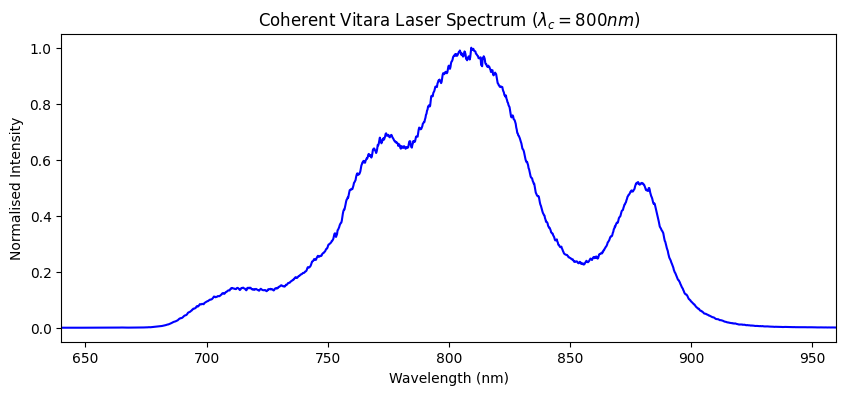

63.0


In [425]:
laser_data_file = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/redspex.txt'

loaded_data_laser = np.loadtxt(laser_data_file)

waves_laser = loaded_data_laser[:,0]
laser_amplitude = loaded_data_laser[:,1]

lambda0 = 800.0  # central wavelength (nm)
c = 2.998e8  # m/s
num_points = 1797




intensity_laser = laser_amplitude**2
print(len(intensity_laser))
intensity_laser =intensity_laser/np.max(intensity_laser)
print(intensity_laser)



plt.figure(figsize=(10,4))
plt.plot(waves_laser,intensity_laser, color ='blue')

plt.xlim(640,960)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalised Intensity")
plt.title("Coherent Vitara Laser Spectrum ($\lambda_c =800nm$)")
#plt.savefig('laser_spectrum_coherent_vitara.png')
plt.show()

w = (884-758)/2
print(w)

### Convert to Angular Frequency

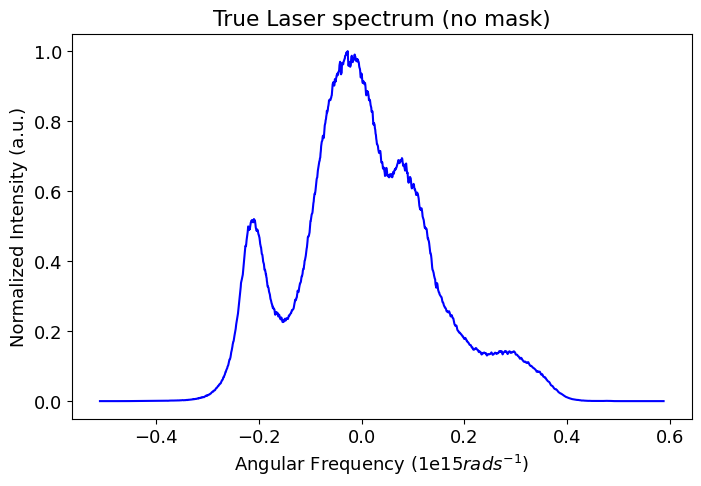

In [370]:
omega_laser = (2*np.pi*c / (waves_laser * 1e-9))/1e15
omega0 = (2*np.pi*c / (lambda0 * 1e-9))/1e15
Omega_laser = omega_laser - omega0  # detuning from central frequency



# Sort ascending for Fourier compatibility
idx_laser = np.argsort(Omega_laser)
omegas_laser, I_omega_laser = Omega_laser[idx_laser],intensity_laser[idx_laser]

plt.figure(figsize=(8,5))
plt.plot(omegas_laser, I_omega_laser, color='blue')
plt.title("True Laser spectrum (no mask)")
plt.xlabel("Angular Frequency (1e15$rads^{-1})$")
plt.ylabel("Normalized Intensity (a.u.)")
#plt.xlim(lambda_min, lambda_max)
#plt.grid(alpha=0.3)
#plt.tight_layout()
plt.show()





## Re-load the phase mask (or create one) and convert it to angular frequency

The first step is to load the real phase data 

In [371]:
#phase_mask = np.loadtxt(title, delimiter =',')    # load the phase mask generated earlier in the file 

##phase_data =phase_mask[:,1]



#phase_data = summation[idx]

The second or alternative would be to generate phase data via simulation

In [372]:

Omega = np.linspace((Omega_laser.min()), (Omega_laser.max()), len(Omega_laser))





a2 = 450 # s^2, adjust to see broadening      #note the model only works up to 470
phase_data_laser = -(a2 *(Omega)**2)

## Create evenly spaced angular frequeny grid for the FFT

Now comes the bit I don't entirely get, something about lineing up the sepctra \

In [373]:
# Create evenly spaced ω grid for FFT
delta_omega_laser = (Omega_laser.max()-Omega_laser.min())/num_points
Omega_uniform_laser = Omega_laser.min() + np.arange(num_points) * delta_omega_laser
#Omega_uniform_laser = np.linspace(Omega_laser.min(), Omega_laser.max(), num_points)
A_interp_laser = interp1d(Omega_laser, laser_amplitude, kind='cubic', fill_value=0, bounds_error=False)
phi_interp_laser = interp1d(Omega_laser, phase_data_laser, kind='cubic', fill_value=0, bounds_error=False)


A_omega_laser = A_interp_laser(Omega_uniform_laser)
phi_omega_laser = phi_interp_laser(Omega_uniform_laser)
print(A_omega_laser)

[-123.3333     -175.74776277 -181.18210971 ...  -33.10200269  -48.54802354
  -80.33195164]


## Apply the phase mask 

In [374]:
E_omega_laser = A_omega_laser * np.exp(1j *phi_omega_laser)

print(len(phi_omega_laser))

1797


## Perform the FFT to the time domain (inverse FFT)

In [375]:
# --- Inverse Fourier Transform to time domain ---
E_t_laser = fftshift(ifft(fftshift(E_omega_laser)))
# Time axis (from frequency sampling)
domega_laser = Omega_uniform_laser[1] - Omega_uniform_laser[0]
dt = 2*np.pi / (num_points * domega_laser)
t_laser = dt * np.arange(-num_points/2, num_points/2)
#t_laser = fftshift(fftfreq(num_points, domega_laser / (2*np.pi)))  # seconds

# --- Temporal intensity ---
I_t_laser = np.abs(E_t_laser)**2
I_t_laser /= np.max(I_t_laser)

## Find the FWHM of the Resultant Temporal Profile

In [376]:
#full_width_half_max_laser, lefts, rights, heights, dx,gh_laser = FWHM(t_laser,I_t_laser)
gh_laser = FWHM_2(t_laser,I_t_laser)
print(gh_laser)

print('The FWHM of the resultant temporal pulse is {0:.3f}fs'.format(gh_laser))

186.4202322698507
The FWHM of the resultant temporal pulse is 186.420fs


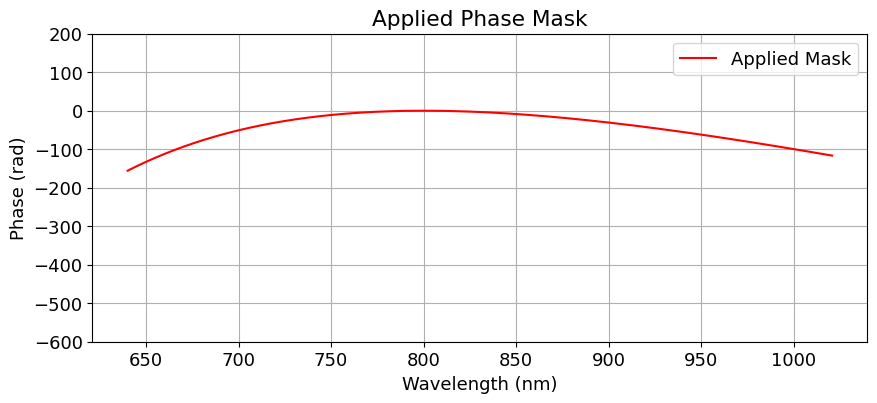

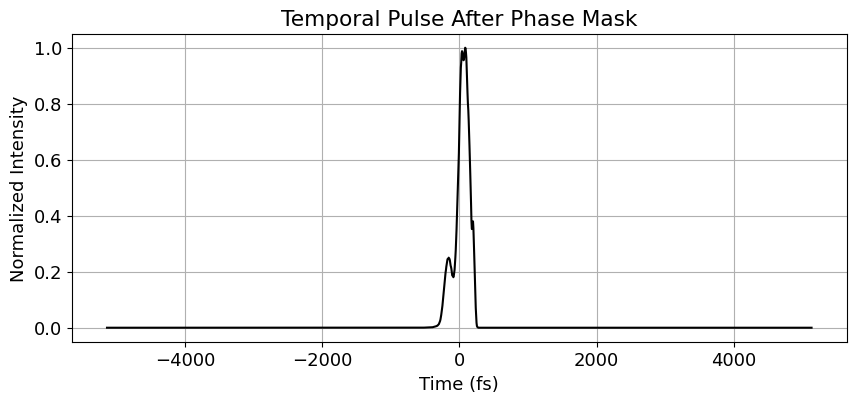

In [377]:

# --- Plot results ---
plt.figure(figsize=(10,4))


plt.plot(waves_laser, phi_omega_laser, color='red', label='Applied Mask')
#plt.plot(waves,-phase, color ='blue', label = "TL Limited Mask")
#plt.plot(waves_laser,intensity_laser, color ='blue')
plt.ylim(-600,200)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Phase (rad)")
plt.title("Applied Phase Mask")
plt.grid()
plt.legend()
plt.show


plt.figure(figsize=(10,4))
plt.plot(t_laser, I_t_laser, 'k')
plt.xlabel("Time (fs)")
plt.ylabel("Normalized Intensity")
plt.title("Temporal Pulse After Phase Mask")
plt.grid(True)
#plt.xlim(-200,400)

plt.show()

## Attempting some Analysis

Analysis of temporal width to GDD coefficient done using real laser data, at this point the phase is still simulated but the hope is that this will be rectidied shortly

In [378]:
phases = np.linspace(1,450,10000)

widths =[]
for i in range(len(phases)):

    a2 = phases[i] # s^2, adjust to see broadening
    phase_data = (a2 * (Omega)**2)  # 

    phi_interp = interp1d(Omega, phase_data, kind='cubic', fill_value=0, bounds_error=False)


    #A_omega = A_interp_laser(Omega_uniform_laser)
    phi_omega = phi_interp(Omega_uniform_laser)
    E_omega = A_omega_laser * np.exp(1j * phi_omega)

    # --- Inverse Fourier Transform to time domain ---
    E_t = fftshift(ifft(fftshift(E_omega)))
    # Time axis (from frequency sampling)
    domega = Omega_uniform_laser[1] - Omega_uniform_laser[0]
    t = fftshift(fftfreq(num_points, domega / (2*np.pi)))  # seconds

    # --- Temporal intensity ---
    I_t = np.abs(E_t)**2
    I_t /= np.max(I_t)

    #full_width_half_max, lefts, rights, heights, dx,fwg = FWHM(t,I_t)
    fwg = FWHM_2(t,I_t)
    #print(full_width_half_max)
    widths.append(float(fwg))

    

print(widths)

[8.872754159535113, 8.873903810072688, 8.875104256825448, 8.876355539235888, 8.877657698421075, 8.879010777174482, 8.88041481996798, 8.881869872953853, 8.883375983966893, 8.8849332025266, 8.886541579839424, 8.88820116880111, 8.889912023999106, 8.891674201715054, 8.893487759927345, 8.895352758313765, 8.897269258254223, 8.899237322833514, 8.90125701684423, 8.903328406789667, 8.905451560886874, 8.90762654906974, 8.909853442992182, 8.912132316031393, 8.914463243291165, 8.916846301605315, 8.919281569541148, 8.921769127403033, 8.924309057236048, 8.92690144282967, 8.929546369721596, 8.93224392520159, 8.934994198315465, 8.937797279869052, 8.940653262432367, 8.943562240343745, 8.946524309714107, 8.949539568431314, 8.952608116164555, 8.955730054368846, 8.95890548628962, 8.962134516967321, 8.965417253242178, 8.968753803758991, 8.972144278971992, 8.975588791149825, 8.979087454380569, 8.982640384576857, 8.986247699481057, 8.989909518670558, 8.993625963563105, 8.997397157422213, 9.001223225362704, 9

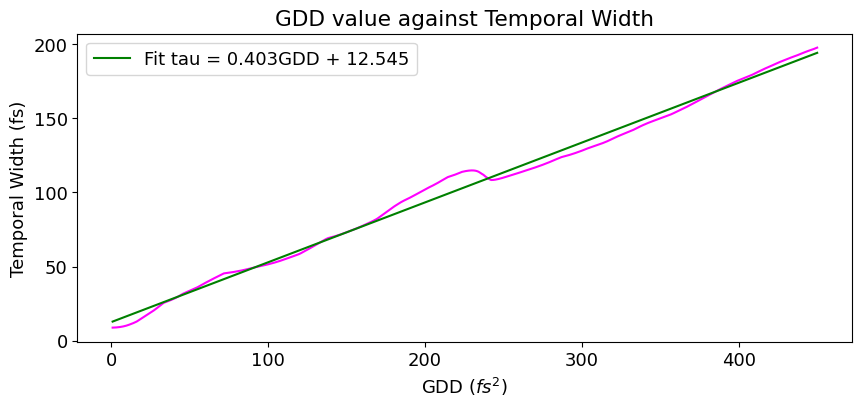

0.4034115525986862 12.545292708220042


In [379]:
params1, params_covariance1 = optimize.curve_fit(linear_func, phases,widths) #Using optimiz.curve_fit to fit a straightline to the data for measured field strength 


plt.figure(figsize=(10,4))
plt.plot(phases, widths, color ='magenta')
plt.plot(phases,linear_func(phases,*params1), color='green', label ='Fit tau = {0:.3f}GDD + {1:.3f}'.format(params1[0],params1[1]))
plt.xlabel("GDD ($fs^2$)")
plt.ylabel("Temporal Width (fs)")
plt.title("GDD value against Temporal Width")
plt.legend()
#plt.xlim(-200,400)


plt.show()

print(params1[0],params1[1])

In [419]:
target_time =25
target_phase = 330
#interp_phase = PchipInterpolator(widths, phases)
interp_phase = interp1d(widths, phases, fill_value="extrapolate")
interp_time = interp1d( phases, widths, fill_value="extrapolate")
#interp_time = PchipInterpolator(phases, widths)
GDD = interp_phase(target_time)
tau = interp_time(target_phase)
print(tau)


140.83944379163466


Based on the results from comparing to the SHG spectrum from the MIIPS box this does not line up with reality (see 'recovered_SHG_check.ipynb'). I suspect however from some research that this is a consequence of trying to recover temporal profile from the SHG rather than a failure of this code. It can be better checked by running checks against the post Box fundamental spectrum. Date 14/11/25

In [411]:
times =[10,15,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
widths2=[]
intensities=[]
temp_profiles=[]
dispersion=[]
for i in range(len(times)):

    #gdd = GDD_from_time(times[i],params1[0],params1[1])
    target = times[i]
    gdd1 = interp_phase(target)
    dispersion.append(gdd1)

    a2 = gdd1 # s^2, adjust to see broadening      #note the model only works up to 470
    phase_data_laser = -(a2 *(Omega)**2)

    # Create evenly spaced ω grid for FFT
    #Omega_uniform_laser = np.linspace(Omega_laser.min(), Omega_laser.max(), num_points)
    #A_interp_laser = interp1d(Omega_laser, laser_amplitude, kind='cubic', fill_value=2000, bounds_error=False)
    phi_interp_laser = interp1d(Omega, phase_data_laser, kind='cubic', fill_value=0, bounds_error=False)


    #A_omega_laser = A_interp_laser(Omega_uniform_laser)
    phi_omega_laser = phi_interp_laser(Omega_uniform_laser)
    #print(A_omega_laser)

    E_omega_laser = A_omega_laser * np.exp(1j *phi_omega_laser)

    # --- Inverse Fourier Transform to time domain ---
    E_t_laser = fftshift(ifft(fftshift(E_omega_laser)))
    # Time axis (from frequency sampling)
    #domega_laser = Omega_uniform_laser[1] - Omega_uniform_laser[0]
    #t_laser = fftshift(fftfreq(num_points, domega_laser / (2*np.pi)))  # seconds

    # --- Temporal intensity ---
    I_t_laser = np.abs(E_t_laser)**2
    I_t_laser /= np.max(I_t_laser)

    
    #full_width_half_max_laser, lefts, rights, heights, dx,gh_laser = FWHM(t_laser,I_t_laser)

    gh_laser = FWHM_2(t_laser,I_t_laser)
    
    widths2.append(float(gh_laser))
    intensities.append(I_t_laser)
    temp_profiles.append(t_laser)


    print('The FWHM of the resultant temporal pulse is {0:.3f}fs'.format(float(gh_laser)))

The FWHM of the resultant temporal pulse is 10.000fs
The FWHM of the resultant temporal pulse is 15.000fs
The FWHM of the resultant temporal pulse is 20.000fs
The FWHM of the resultant temporal pulse is 30.000fs
The FWHM of the resultant temporal pulse is 40.000fs
The FWHM of the resultant temporal pulse is 50.000fs
The FWHM of the resultant temporal pulse is 60.000fs
The FWHM of the resultant temporal pulse is 70.000fs
The FWHM of the resultant temporal pulse is 80.000fs
The FWHM of the resultant temporal pulse is 90.000fs
The FWHM of the resultant temporal pulse is 100.000fs
The FWHM of the resultant temporal pulse is 109.053fs
The FWHM of the resultant temporal pulse is 120.000fs
The FWHM of the resultant temporal pulse is 130.000fs
The FWHM of the resultant temporal pulse is 140.000fs
The FWHM of the resultant temporal pulse is 150.000fs
The FWHM of the resultant temporal pulse is 160.000fs
The FWHM of the resultant temporal pulse is 170.000fs
The FWHM of the resultant temporal pul

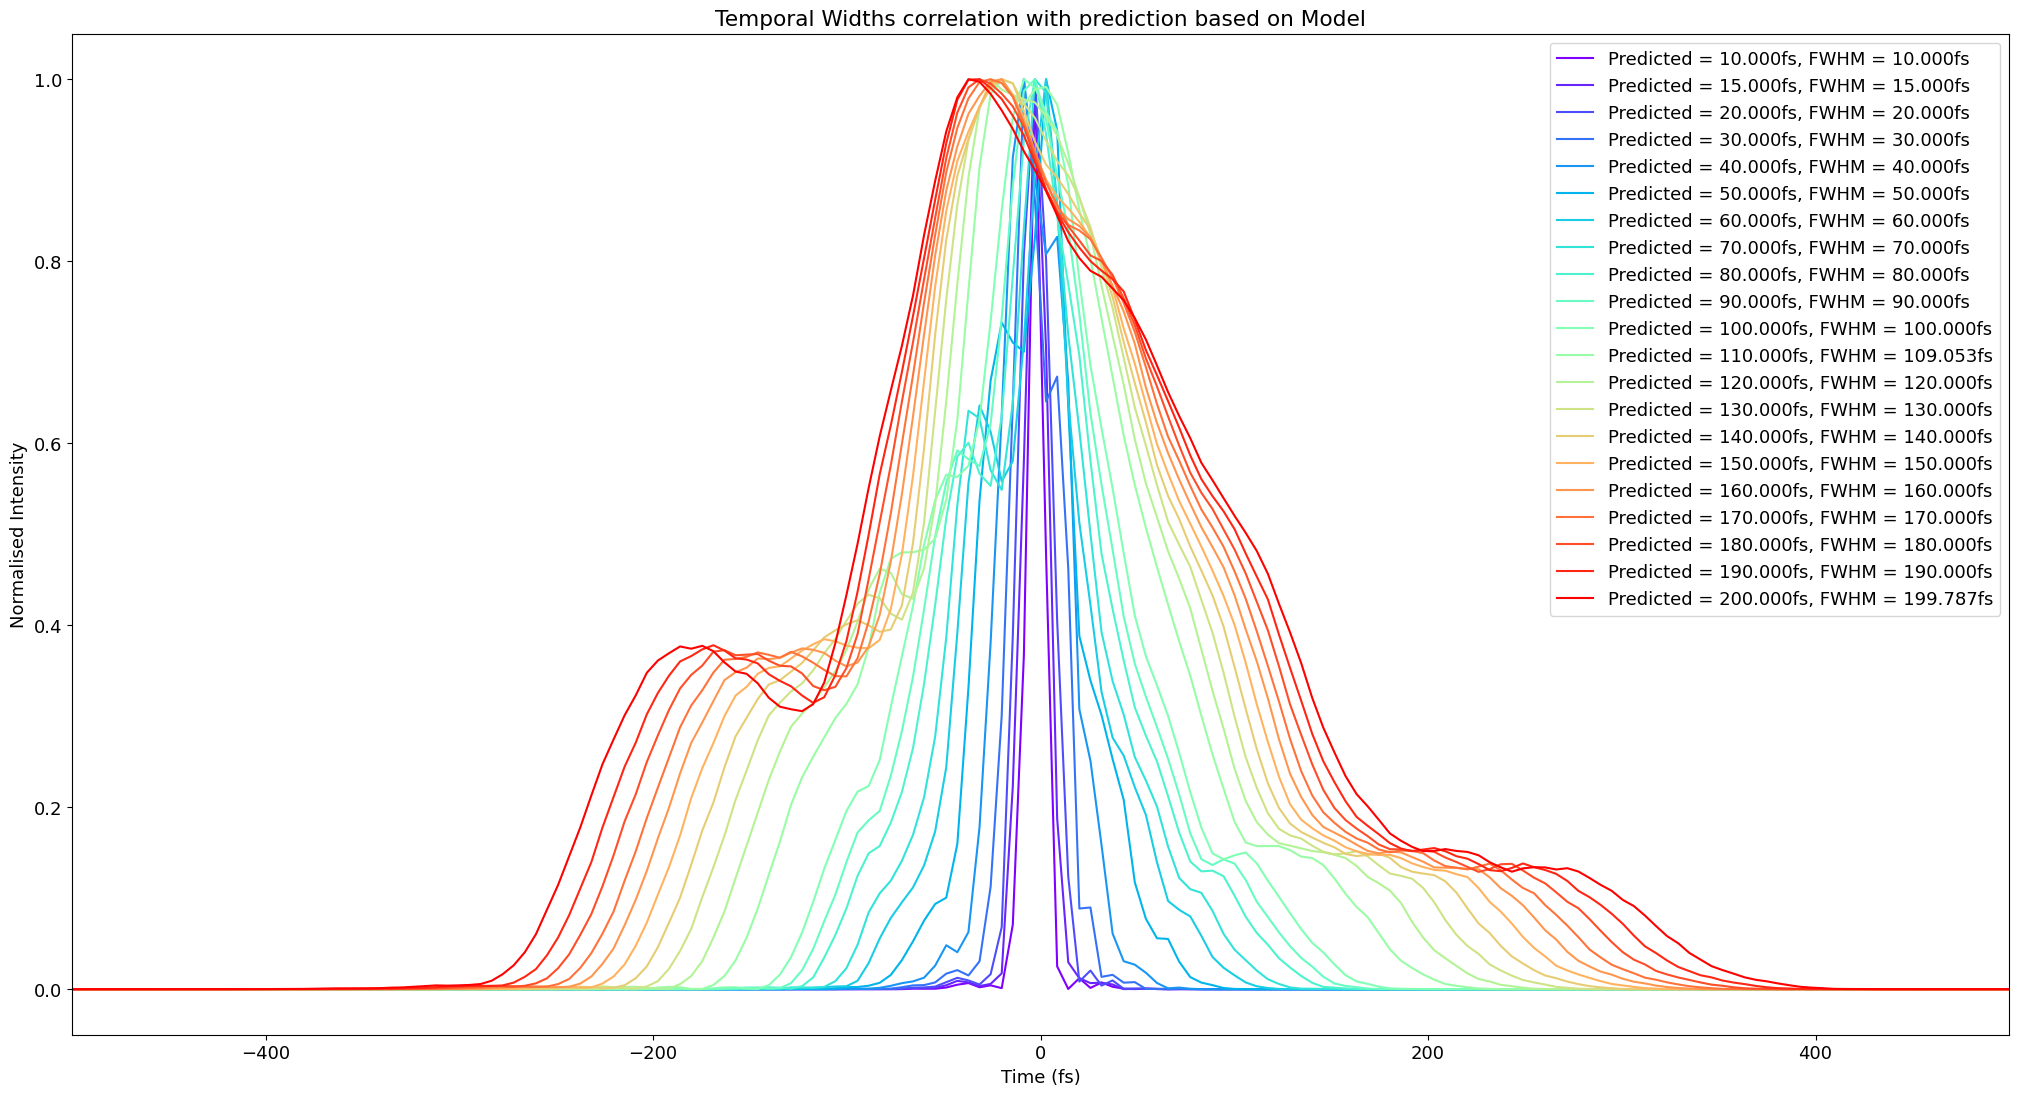

In [412]:
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(widths2))))
cmap = plt.get_cmap('rainbow', len(widths2))
print(cmap)

plt.figure(figsize=(25,13))
for i in range(len(intensities)):
    c = next(color)
    plt.plot(temp_profiles[i],intensities[i], color =c, label ='Predicted = {0:.3f}fs, FWHM = {1:.3f}fs'.format(times[i],widths2[i] ))

plt.xlabel("Time (fs)")

plt.ylabel("Normalised Intensity")
plt.title("Temporal Widths correlation with prediction based on Model")
plt.legend()
plt.xlim(-500,500)
#title ='Temporal_Widths_Correlation_with_prediction_141125.png'
#plt.savefig(title)
plt.show()

In [413]:
phoses =np.linspace(0,450,30)
widths3=[]
intensities3=[]
temp_profiles3=[]
predicted_times=[]

for i in range(len(phoses)):

    
    a2 = phoses[i] # s^2, adjust to see broadening      #note the model only works up to 470
    
    tau1= interp_time(a2)
    
    predicted_times.append(tau1)
    phase_data_laser = -(a2 *(Omega)**2)

    # Create evenly spaced ω grid for FFT
    #Omega_uniform_laser = np.linspace(Omega_laser.min(), Omega_laser.max(), num_points)
    #A_interp_laser = interp1d(Omega_laser, laser_amplitude, kind='cubic', fill_value=2000, bounds_error=False)
    phi_interp_laser = interp1d(Omega, phase_data_laser, kind='cubic', fill_value=0, bounds_error=False)


    #A_omega_laser = A_interp_laser(Omega_uniform_laser)
    phi_omega_laser = phi_interp_laser(Omega_uniform_laser)
    #print(A_omega_laser)

    E_omega_laser = A_omega_laser * np.exp(1j *phi_omega_laser)

    # --- Inverse Fourier Transform to time domain ---
    E_t_laser = fftshift(ifft(fftshift(E_omega_laser)))
    # Time axis (from frequency sampling)
    #domega_laser = Omega_uniform_laser[1] - Omega_uniform_laser[0]
    #t_laser = fftshift(fftfreq(num_points, domega_laser / (2*np.pi)))  # seconds

    # --- Temporal intensity ---
    I_t_laser = np.abs(E_t_laser)**2
    I_t_laser /= np.max(I_t_laser)

    #full_width_half_max_laser, lefts, rights, heights, dx,gh_laser = FWHM(t_laser,I_t_laser)
    gh_laser = FWHM_2(t_laser,I_t_laser)

    widths3.append(float(gh_laser))
    intensities3.append(I_t_laser)
    temp_profiles3.append(t_laser)


    #print('The FWHM of the resultant temporal pulse is {0:.3f}fs'.format(float(gh_laser)))

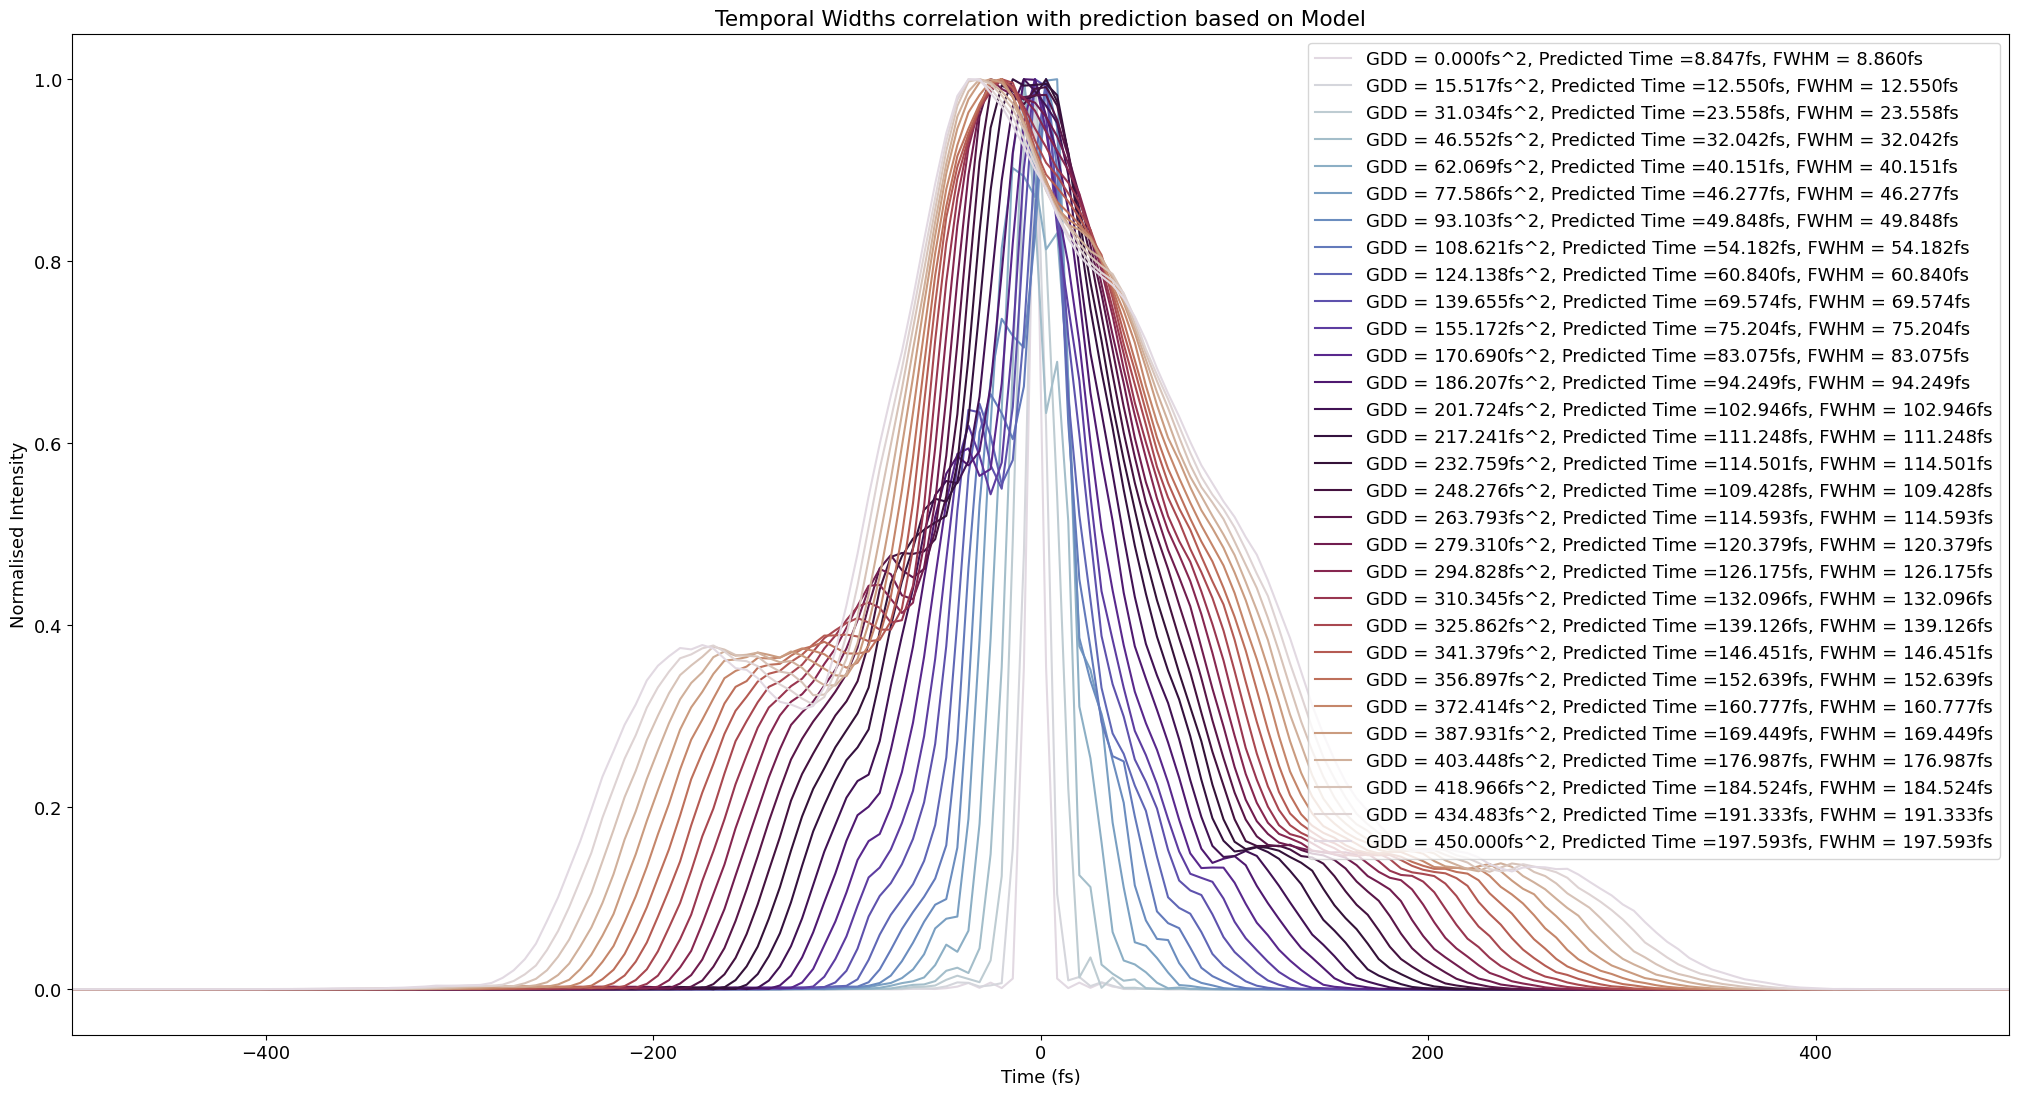

In [414]:
color = iter(plt.cm.twilight(np.linspace(0, 1, len(widths3))))
cmap = plt.get_cmap('rainbow', len(widths3))


plt.figure(figsize=(25,13))
for i in range(len(intensities3)):
    c = next(color)
    plt.plot(temp_profiles3[i],intensities3[i], color =c, label ='GDD = {0:.3f}fs^2, Predicted Time ={1:.3f}fs, FWHM = {2:.3f}fs'.format(phoses[i],predicted_times[i],widths3[i]) )

plt.xlabel("Time (fs)")
plt.ylabel("Normalised Intensity")
plt.title("Temporal Widths correlation with prediction based on Model")
plt.legend()
plt.xlim(-500,500)
#title ='Temporal_Widths_Correlation_with_prediction_141125.png'
#plt.savefig(title)
plt.show()